In this notebook we will take a look at different pancreatic cancer cell lines and examine them with similar analysis methods as before.

# Part 0: Data Preparation

In [1]:
# importing data analysis libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

In [2]:
def prepare_dataset(ds):
    table = pd.read_csv(ds, delimiter=',')
    table.drop('Unnamed: 0', axis=1, inplace=True)
    return table

coad_all = prepare_dataset('datasets/COAD_hgnc.csv')
lihc_all = prepare_dataset('datasets/LIHC_hgnc.csv')
prad_all = prepare_dataset('datasets/PRAD_hgnc.csv')

In [3]:
# might come back to deal with this warning? it gets the result for now
pd.options.mode.chained_assignment = None

# Part 1: Calculating TPM

Now that all of our csv files are imported, we can calculate TPM values for them. this function below is from the original cancer_expression_heatmap notebook file.

In [4]:
import pyensembl
ensembl = pyensembl.EnsemblRelease()

In [5]:
def calculate_rpk(sample_count, gene_length):
    if gene_length == 0:
        return 0
    reads_per_kilobase = sample_count / gene_length
    return reads_per_kilobase

def calculate_per_million(total_reads):
    return total_reads / 1000000

            
def find_gene_length_ensembl(gene_name):
    try:
        gene_search = ensembl.genes_by_name(gene_name)
        gene_length = (gene_search[0].end - gene_search[0].start) / 1000
        # clear the gene search cache
        gene_search = None
        return gene_length
    except:
        return 0


def calculate_tpm(table, table_columns):
    
    missing_genes_dict = {'C12orf74':'PLEKHG7',
                     'LINC00856':'LINC00595'}

    precalculated_gene_length_dict = {'CCL3L1': 3.090, 'RP11-34P13.7': 2.748, 
                                      'RP11-34P13.15':0.755, 'RP11-34P13.14':0.323,
                                      'RP11-34P13.13':1.301, 'RP11-34P13.9':0.457,
                                      'RP4-669L17.10':0.457, 'RP4-669L17.8':1.239,
                                      'RP4-669L17.4':2.017, 'RP4-669L17.2':0.324,
                                      'RP5-857K21.15':2.3, 'RP4-669L17.1':0.385,
                                      'RP5-857K21.1':0.845, 'RP5-857K21.2':123.115,
                                      'RP5-857K21.3':1.543, 'RP5-857K21.4':0.413,
                                      'RP5-857K21.5':1.634, 'hsa-mir-6723':1.543,
                                      'RP5-857K21.7':0.682, 'RP5-857K21.11':0.547,
                                      'RP11-206L10.1':13.770, 'RP11-206L10.3':4.860,
                                      'RP11-206L10.5':9.283, 'RP11-206L10.4':7.604, 'RP11-206L10.2':13.770,
                                      'RP11-206L10.9':8.204, 'RP11-206L10.8':2.746, 'RP11-206L10.10':2.823,
                                      'RP11-206L10.11':1.079, 'RP11-54O7.16':0.351, 'RP11-54O7.1':3.043,
                                      'RP11-54O7.2':0.156, 'RP11-54O7.3':1.389, 'C1orf170':3.035}

    # converting this to numpy array so it's easier to work with
    # doing this loses the indexing that the original rnaseq table has but 
    # can be added back in later
    table_numpy = table.to_numpy(copy=True)
    
    
    ## -------- FOR CALCULATING RPK ----------
    rpk_table = table_numpy
    gene_length = 0

    for index, value in np.ndenumerate(table_numpy):
        if index[1] == 0:
            gene = value
            if gene in precalculated_gene_length_dict:
                gene_length = precalculated_gene_length_dict.get(value)
            else:
                if gene in missing_genes_dict:
                    gene = missing_genes_dict.get(value)
                gene_length = find_gene_length_ensembl(gene)

                
        else:
            rpk_table[index[0], index[1]] = calculate_rpk(value, gene_length)

    ## ---- FOR CALCULATING PER MILLION SCALING FACTOR -----
    per_mil_table = rpk_table
    
    total_reads = np.sum(rpk_table[:, 1:], axis=0)
    
    for index, value in np.ndenumerate(rpk_table):
        if (index[1] == 0):
            continue
        total_for_column = total_reads[index[1] - 1]
        
        scaling_factor = calculate_per_million(total_for_column)
        
        # this value references the rpk_table
        per_mil_table[index[0], index[1]] = value / scaling_factor
    
    tpm_table = pd.DataFrame(per_mil_table, columns=table_columns)
    
    return tpm_table

In [6]:
neurotransmitter_genes = pd.read_csv('datasets/neurotransmitter_gene_family.csv', delimiter = ',')

def filter_genes_of_interest(table):
    # take the RNASeq data table to only include genes of interest
    rnaseq_goi = table[table['hgnc_symbol'].isin(neurotransmitter_genes["receptor gene"])]
    return rnaseq_goi

def sort_genes_of_interest(table):
    
    receptor_gene_list = neurotransmitter_genes['receptor gene'].tolist()
    
    table.loc[:, 'hgnc_symbol'] = pd.Categorical(table['hgnc_symbol'], categories = receptor_gene_list, ordered = True)
    table = table.sort_values('hgnc_symbol')
    return table

In [7]:
def make_tpm(table):
    
    all_tpm = calculate_tpm(table, list(table.columns.values))
    tpm_goi = filter_genes_of_interest(all_tpm)
    tpm_sorted = sort_genes_of_interest(tpm_goi)
    
    return tpm_sorted

In [8]:
coad_tpm = make_tpm(coad_all)

In [9]:
lihc_tpm = make_tpm(lihc_all)

In [10]:
prad_tpm = make_tpm(prad_all)

# Part 2: Generating Heatmaps

Now we can generate heatmaps for each of the three cell lines. For each of the cell lines, we'll make a regular TPM heatmap, a zscore TPM heatmap, and a zscore log (TPM +!)

I'm importing the functions written in cancer_expression_heatmap.

In [42]:
def draw_expression_log_heatmap(table, y_axis_list, log_type, title, compute_zscore, sort, cmap, width, height, save):
    # the inital data table contains a column of gene names, and then the rest of the columns are expression values.
    # we get rid of the gene name column because otherwise we won't be able to plot it.
    htseq_count_values = table.drop('hgnc_symbol', axis=1)
    # here we are converting pandas dataframe to numpy array, so we can perform calculations with it
    # maybe think of dataframe like an excel spreadsheet, and the numpy table as a list of list of numbers, it's 
    # easier to do calculations on the numpy table (at least for me?)
    expression_grid = htseq_count_values.to_numpy(copy=True, dtype=float)
    # this is all of the cases put into list format
    rnaseq_columns = list(table.columns.values)
    # if you look in the function above, log_type is an argument-- meaning it gets passed to this function. we specify
    # if we want natural or base-10, or nothing
    if log_type == 'natural':
        # if we wanted it to convert to log, then it adds 1 to each value in our numpy array
        expression_grid = expression_grid + 1
        # here we can take the log of the entire table easily
        expression_logged = np.log(expression_grid)
    elif log_type == 'base-10':
        # same actions done, but for the case of base10 conversiona
        expression_grid = expression_grid + 1
        expression_logged = np.log10(expression_grid)
    else:
        # nothing gets specified, but we use expression_logged as our table to actually plot our heatmap
        # so to condense code down and not have 1000 if statements, we can just set our original expression_grid
        # to expression_logged
        expression_logged = expression_grid
        
    #boolean for if we want to sort the table by family of neurotransmitter genes
    if sort:
        # this part is kind of annoying. i had already written a sort_table function that takes in a pandas
        # dataframe as the parameter, but here i have a numpy table
        # instead of re-writing the numpy table, i just converted it back into a pandas dataframe, sent it to
        # sort_table, and then converted it back all sorted
        expression_logged_pandas = convert_numpy_to_pandas(expression_logged, rnaseq_columns[1:])
        expression_logged_pandas_sorted = sort_table(expression_logged_pandas, htseq_count_values.columns.values[0] == 'Tumor')
        # obviously if we change the order of the gene listings, we override the original y_axis_list parameter 
        # we passed into this function with the new sorted version
        y_axis_list = expression_logged_pandas_sorted['hgnc_symbol'].tolist()
        expression_logged = convert_pandas_to_numpy(expression_logged_pandas_sorted)
        
    # this is a boolean (true false) for if we want to compute the z score or not
    if compute_zscore:
        # here we're going to calculate the z-scores separately per column in the case that its a comparative map
        comparative_zscore = []
        if htseq_count_values.columns.values[0] == 'Tumor':
            for i in range(len(htseq_count_values.columns.values)):
                column_zscore = z_score(expression_logged[:, i])
                #column_reshaped = np.reshape(column_zscore, (-1, 1))
                comparative_zscore.append(column_zscore)
            expression_logged = np.transpose(np.array(comparative_zscore)) 
        else:
        # the table output of the z_score function gets set as expression logged
        # every time you set a variable, it overrides the previous set
            expression_logged = z_score(expression_logged)
        
    # we use the seaborn library to plot the heatmap, give it the numpy table, and specify some other stuff
    if cmap=='coolwarm' or cmap=='bwr':
        # for the comparison cell lines heatmap
        if htseq_count_values.columns.values[0] == 'Tumor':
            if sort:
                x_axis_list = list(expression_logged_pandas_sorted.columns.values)[1:]
            else:
                x_axis_list = list(htseq_count_values.columns.values)
            sns.heatmap(expression_logged, yticklabels=y_axis_list, xticklabels=x_axis_list, cmap=cmap, norm=colors.DivergingNorm(0))
        else:
            sns.heatmap(expression_logged, yticklabels=y_axis_list, cmap=cmap, norm=colors.DivergingNorm(0))
    else:
        # for the comparison cell lines heatmap
        if htseq_count_values.columns.values[0] == 'Tumor':
            x_axis_list = list(htseq_count_values.columns.values)
            sns.heatmap(expression_logged, yticklabels=y_axis_list, xticklabels=x_axis_list, cmap=cmap)
        else:
            sns.heatmap(expression_logged, yticklabels=y_axis_list, cmap=cmap)
    
    
    # cmap refers to color map, and this other stuff is to make the map look prettier
    plt.title(title, fontsize=20, y=1.15)
    
    
        #colors.DivergingNorm(vmin=expression_logged.min(axis=None), vcenter=expression_logged.min(axis=None)+0.001, vmax=expression_logged.max(axis=None))
        
    plt.ylabel('Gene')
    plt.xlabel('Cases')
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(width, height)
    
    if save:
        file_path = 'output/' + title.replace(' ', '_') + '.svg'
        plt.savefig(file_path, format='svg', dpi=1200)

In [12]:
from scipy import stats

In [13]:
def z_score(numpy_table):
    z_scored = stats.zscore(numpy_table, axis=None)
    return z_scored

receptor_gene_list = neurotransmitter_genes['receptor gene'].tolist()

def convert_numpy_to_pandas(numpy_table, table_columns):
    pandas_table = pd.DataFrame(numpy_table, columns=table_columns)
    pandas_table.insert(0, 'hgnc_symbol', receptor_gene_list)
    return pandas_table

def convert_pandas_to_numpy(pandas_table):
    as_numpy = pandas_table.drop('hgnc_symbol', axis=1)
    return as_numpy.to_numpy(dtype=float)

def sort_table(table, comparative):
    # creating a new table for sorting purposes
    rnaseq_orig = table.copy()
    
    # converting the neurotransmitter dataframe table into a python dict
    neuro_genes_dict = {}
    for index, row in neurotransmitter_genes.iterrows():
        value = row[0]
        if (value in neuro_genes_dict):
            gene_list = neuro_genes_dict[value]
        else:
            gene_list = []
        gene_list.append(row[1])
        neuro_genes_dict[value] = gene_list
    
    # sort table wasn't working right with decimals, so hgnc symbol column was removed
    excluded = rnaseq_orig.loc[:, 'hgnc_symbol']
    rnaseq_orig.drop('hgnc_symbol', axis=1, inplace=True)
    rnaseq_orig.loc[:, 'Total by row'] = rnaseq_orig.sum(axis=1)
    rnaseq_with_total = pd.concat([excluded.rename('hgnc_symbol'), rnaseq_orig], axis=1)
    
    table_columns = list(table.columns.values)
    
    # SORTING THE ROWS -------
    rnaseq_sorted = pd.DataFrame(columns=table_columns)
    
    # sorts the rows section by section, based on the size of each family of neurotransmitters
    index_begin = 0
    index_end = 0
    appended_data = []
    for family, gene_list in neuro_genes_dict.items():
        index_end = len(gene_list) + index_begin
        to_sort = rnaseq_with_total[index_begin : index_end].sort_values('Total by row', ascending=True)
        appended_data.append(to_sort)
        index_begin = index_end
    # the families were sorted as separate dataframes and then concat together
    rnaseq_sorted = pd.concat(appended_data)
    
    if comparative:
        rnaseq_sorted.drop('Total by row', axis=1, inplace=True)
        return rnaseq_sorted
    
    # adding the column sum back in so now we can sort by column
    rnaseq_sorted_2 = rnaseq_sorted.to_numpy(copy=True)
    rnaseq_sorted = pd.DataFrame(rnaseq_sorted_2)
    
    table_columns.append('Total by row')
    rnaseq_sorted.columns = table_columns
    rnaseq_sorted.loc['Total by col', :] = rnaseq_with_total.sum(axis=0)
    table_columns.remove('Total by row')
    
    # SORTING THE COLUMNS ----------
    
    # remove hgnc_symbol column, sort the values, and then remove the total col and total row   
    excluded_after_row_sorting = rnaseq_sorted.loc[:, 'hgnc_symbol']
    del rnaseq_sorted['hgnc_symbol']
    sorted_cases = rnaseq_sorted.sort_values('Total by col', axis=1, ascending=True)
    rnaseq_sorted = pd.concat([excluded_after_row_sorting.rename('hgnc_symbol'), sorted_cases], axis=1)
    rnaseq_sorted.drop('Total by col', axis=0, inplace=True)
    rnaseq_sorted.drop('Total by row', axis=1, inplace=True)
    return rnaseq_sorted

In [43]:
def draw_expression_heatmap(table, y_axis_list, cmap, title, width, height, save):
    # convert this dataframe made with the pandas library to an array that is usable with the numpy
    # library to create heatmap
    htseq_count_values = table.drop('hgnc_symbol', axis=1)
    expression_grid = htseq_count_values.to_numpy(copy=True, dtype=float)
    
    if htseq_count_values.columns.values[0] == 'Tumor':
        x_axis_list = list(htseq_count_values.columns.values)
        sns.heatmap(expression_grid, yticklabels=y_axis_list, xticklabels=x_axis_list, cmap=cmap)
    else:
        sns.heatmap(expression_grid, yticklabels=y_axis_list, cmap=cmap)
    
    plt.title(title, fontsize=20, y=1.15)
    
    plt.ylabel('Gene')
    plt.xlabel('Cases')
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(width, height)
    
    if save:
        file_path = 'output/' + title.replace(' ', '_') + '.svg'
        plt.savefig(file_path, format='svg', dpi=1200)

## Part 2.a -- COAD Line

TPM Heatmap:

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


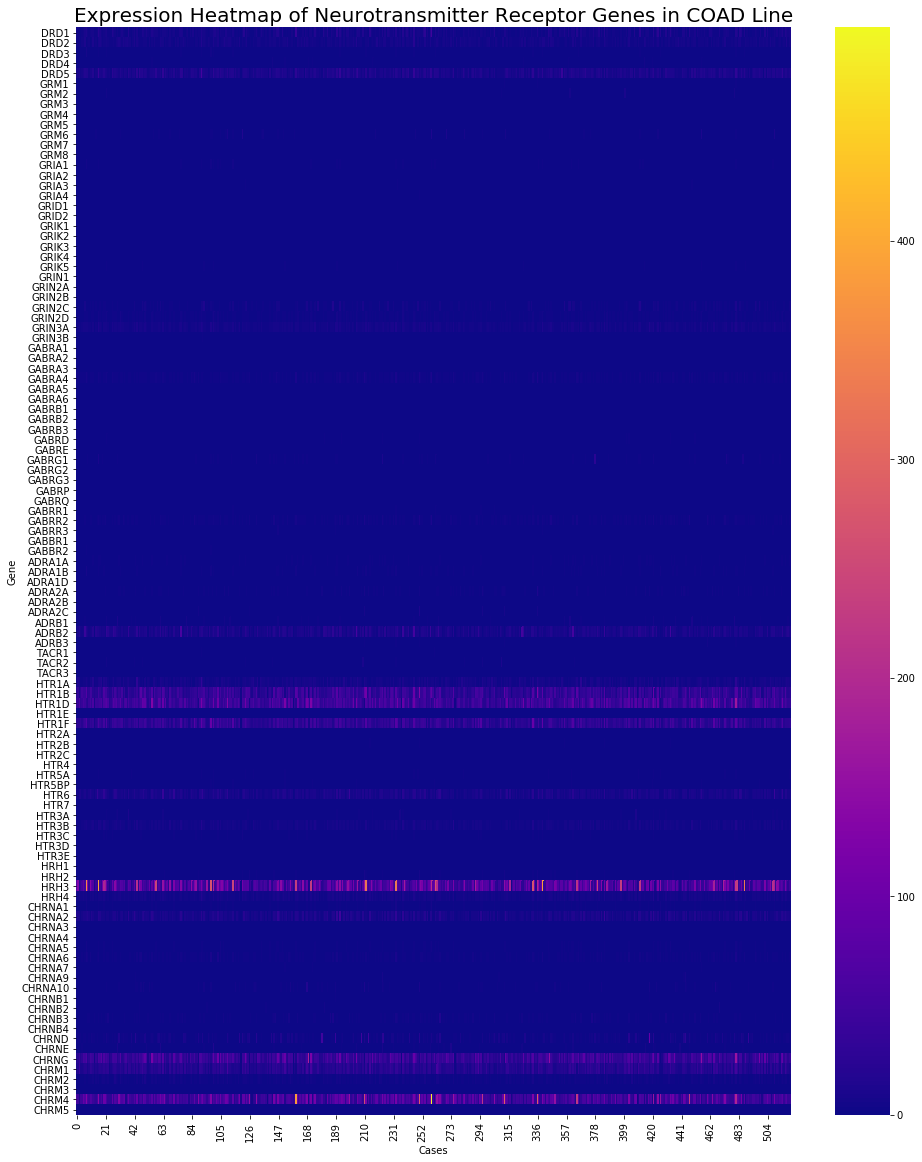

In [16]:
draw_expression_heatmap(coad_tpm, coad_tpm['hgnc_symbol'].tolist(), 'plasma', 'Expression Heatmap of Neurotransmitter Receptor Genes in COAD Line',16, 20, False)

Z-Score TPM Heatmap:

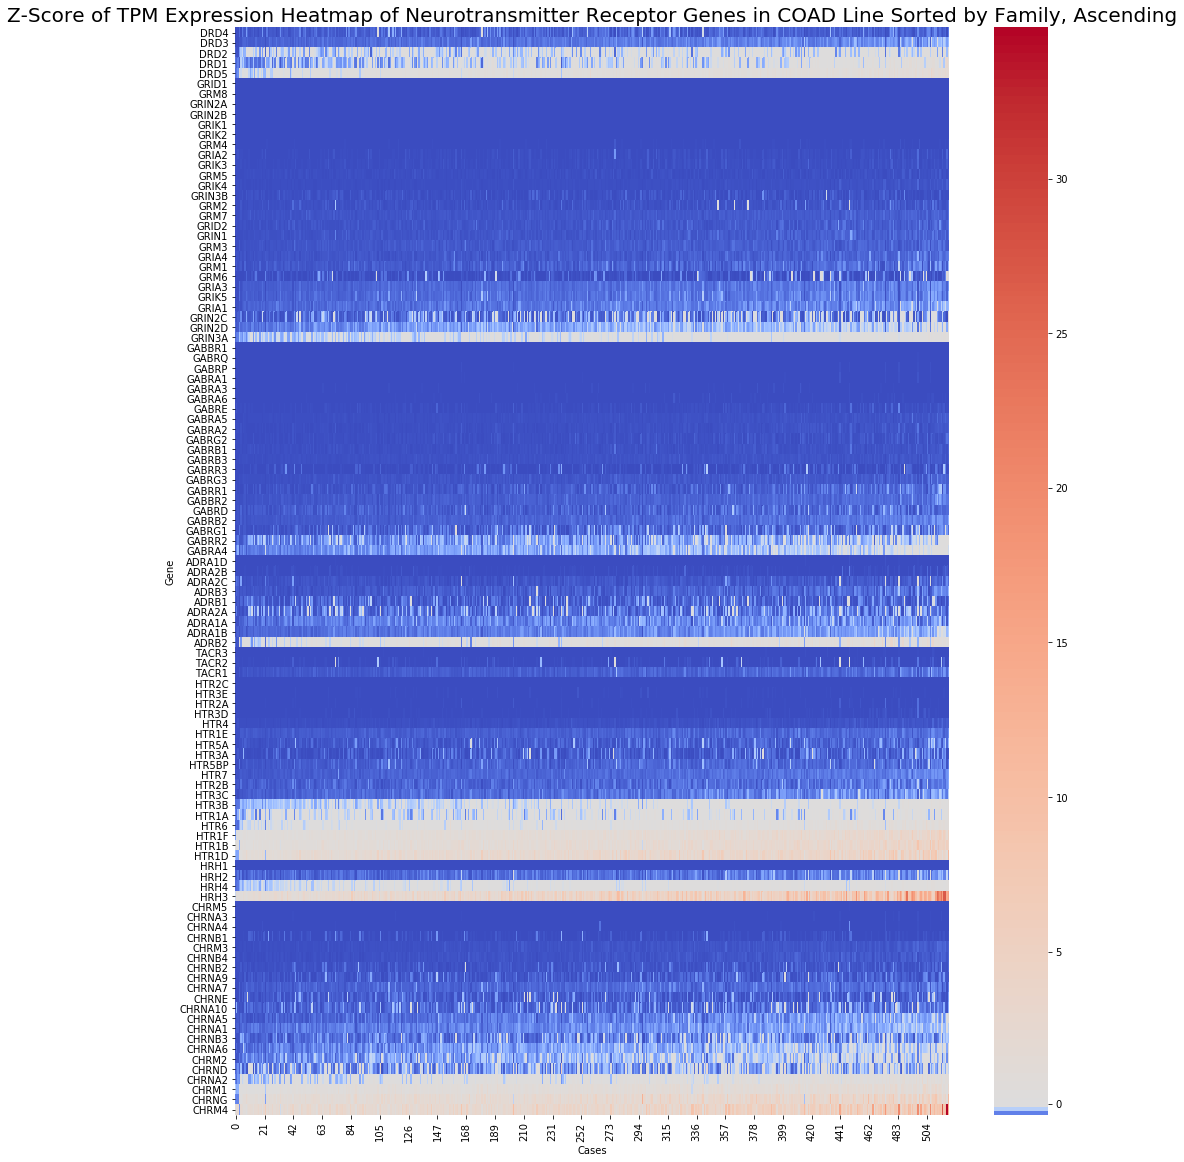

In [17]:
draw_expression_log_heatmap(coad_tpm, coad_tpm['hgnc_symbol'].tolist(), '', 'Z-Score of TPM Expression Heatmap of Neurotransmitter Receptor Genes in COAD Line Sorted by Family, Ascending', True, True, 'coolwarm', 16, 20, False)

Z-Score of Ln (TPM + 1) Heatmap:

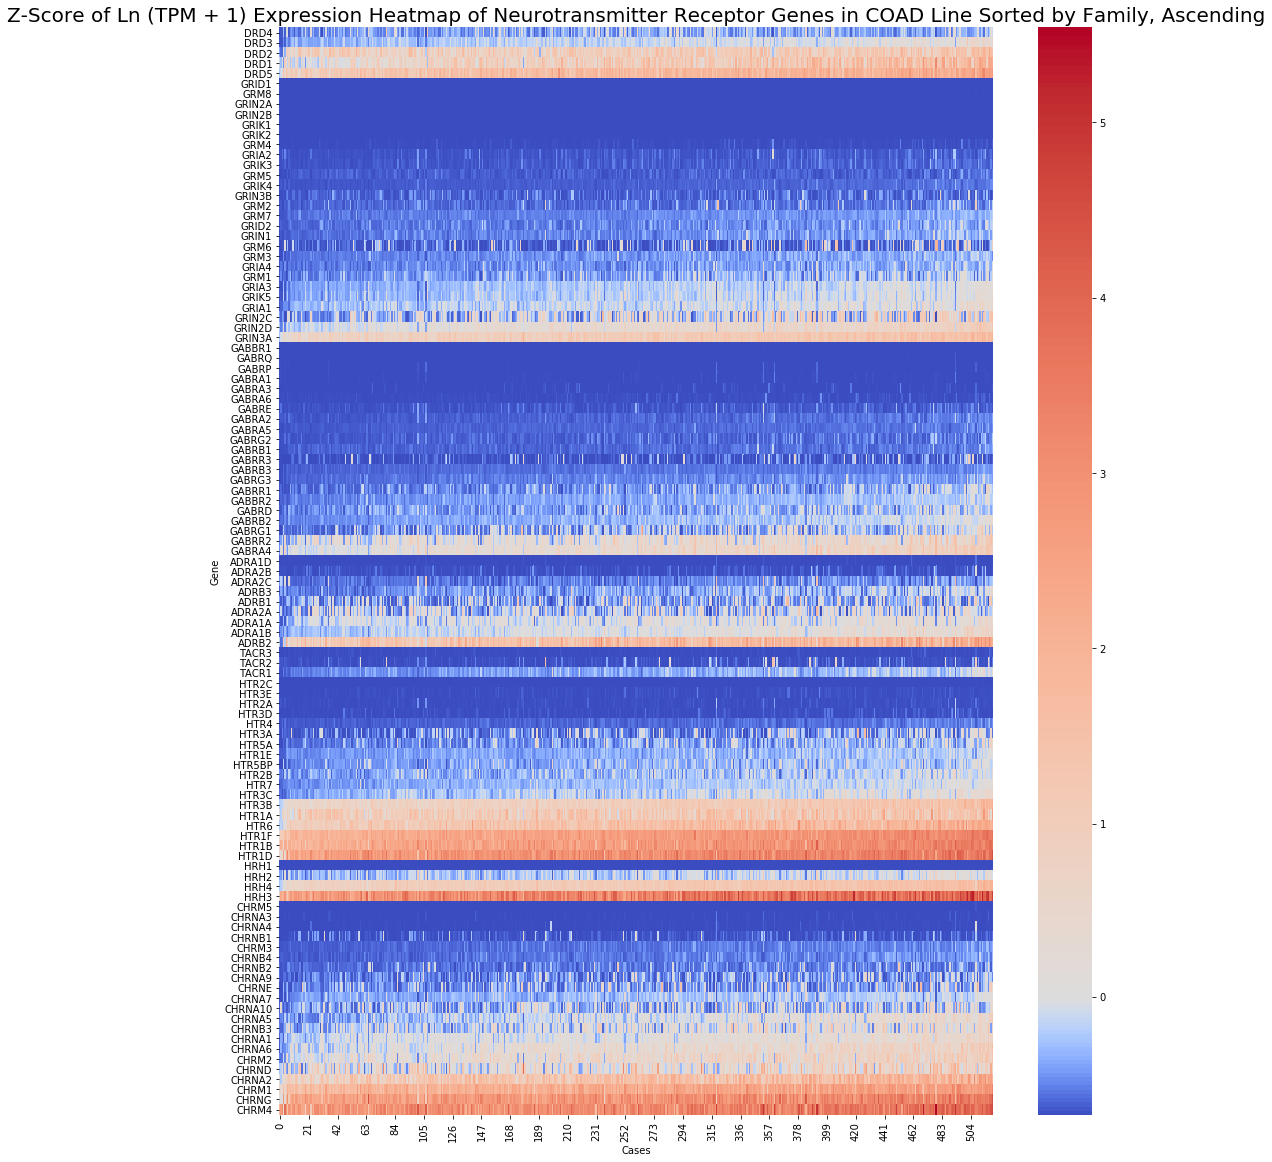

In [18]:
draw_expression_log_heatmap(coad_tpm, coad_tpm['hgnc_symbol'].tolist(), 'natural', 'Z-Score of Ln (TPM + 1) Expression Heatmap of Neurotransmitter Receptor Genes in COAD Line Sorted by Family, Ascending', True, True, 'coolwarm', 16, 20, False)

## Part 2.b -- LIHC Line

TPM Heatmap:

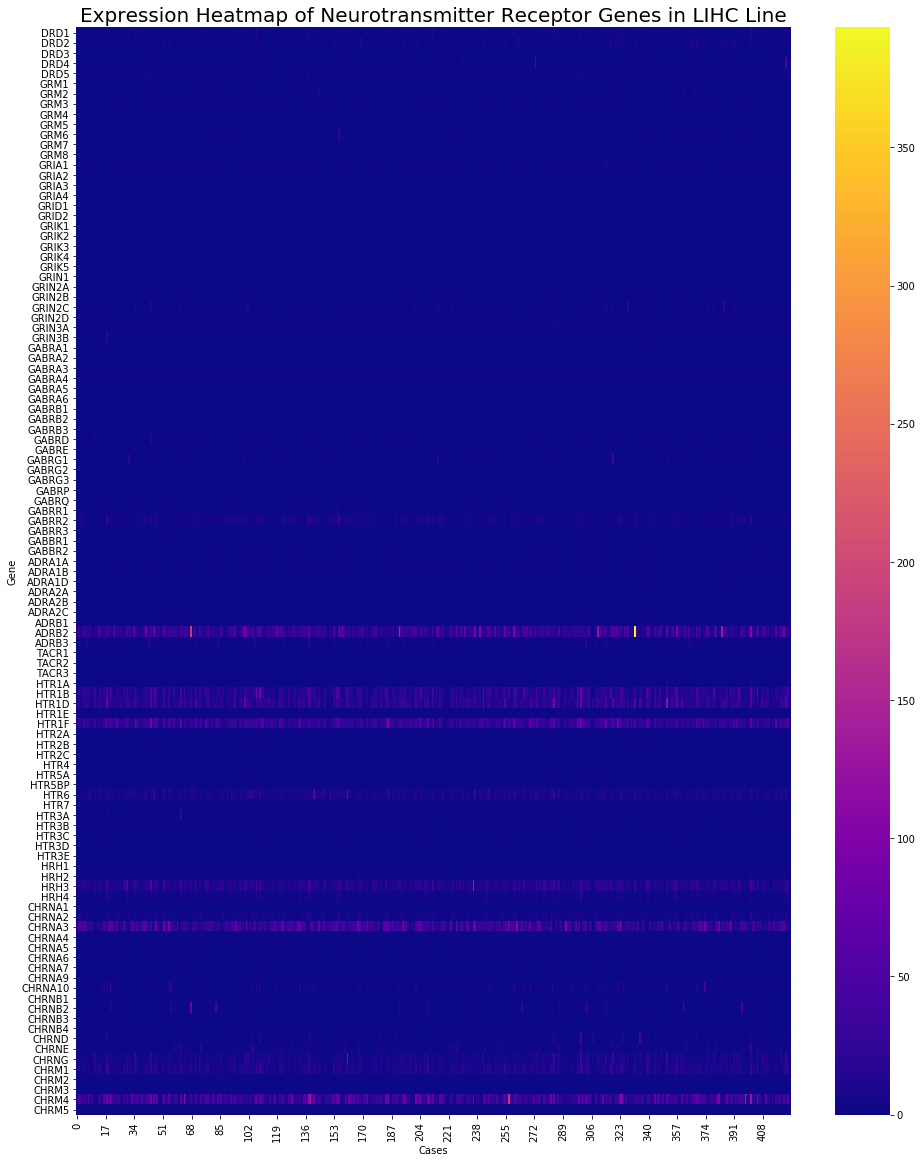

In [19]:
draw_expression_heatmap(lihc_tpm, lihc_tpm['hgnc_symbol'].tolist(), 'plasma', 'Expression Heatmap of Neurotransmitter Receptor Genes in LIHC Line', 16, 20)

Z-Score TPM Heatmap:

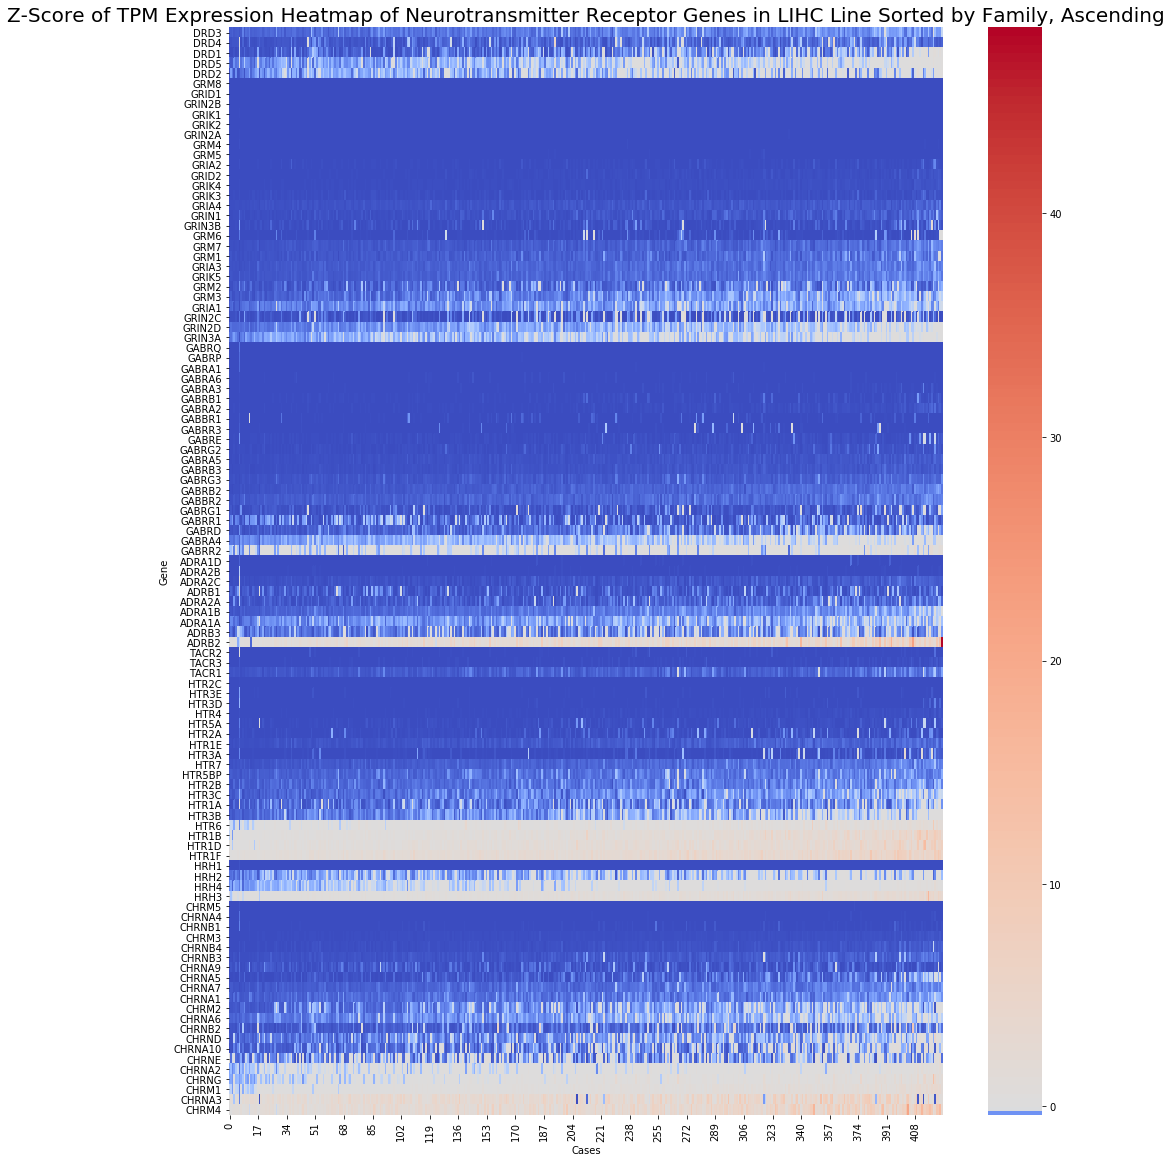

In [20]:
draw_expression_log_heatmap(lihc_tpm, lihc_tpm['hgnc_symbol'].tolist(), '', 'Z-Score of TPM Expression Heatmap of Neurotransmitter Receptor Genes in LIHC Line Sorted by Family, Ascending', True, True, 'coolwarm', 16, 20, False)

Z-Score of Ln (TPM + 1) Heatmap:

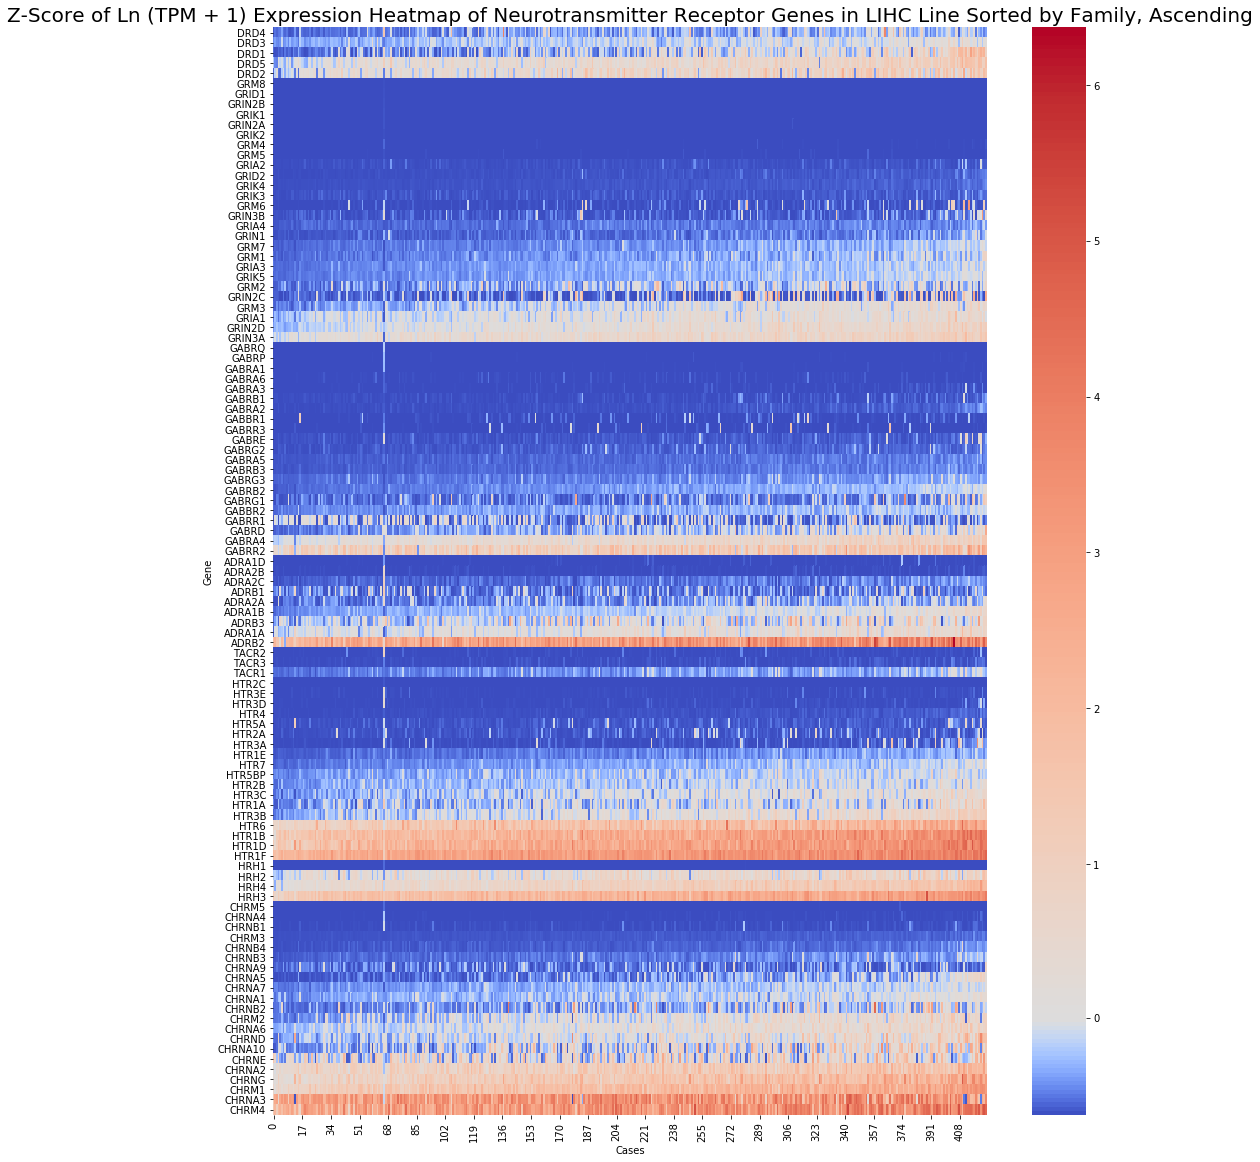

In [21]:
draw_expression_log_heatmap(lihc_tpm, lihc_tpm['hgnc_symbol'].tolist(), 'natural', 'Z-Score of Ln (TPM + 1) Expression Heatmap of Neurotransmitter Receptor Genes in LIHC Line Sorted by Family, Ascending', True, True, 'coolwarm', 16, 20, False)

## Part 2.c -- PRAD Line

TPM Heatmap:

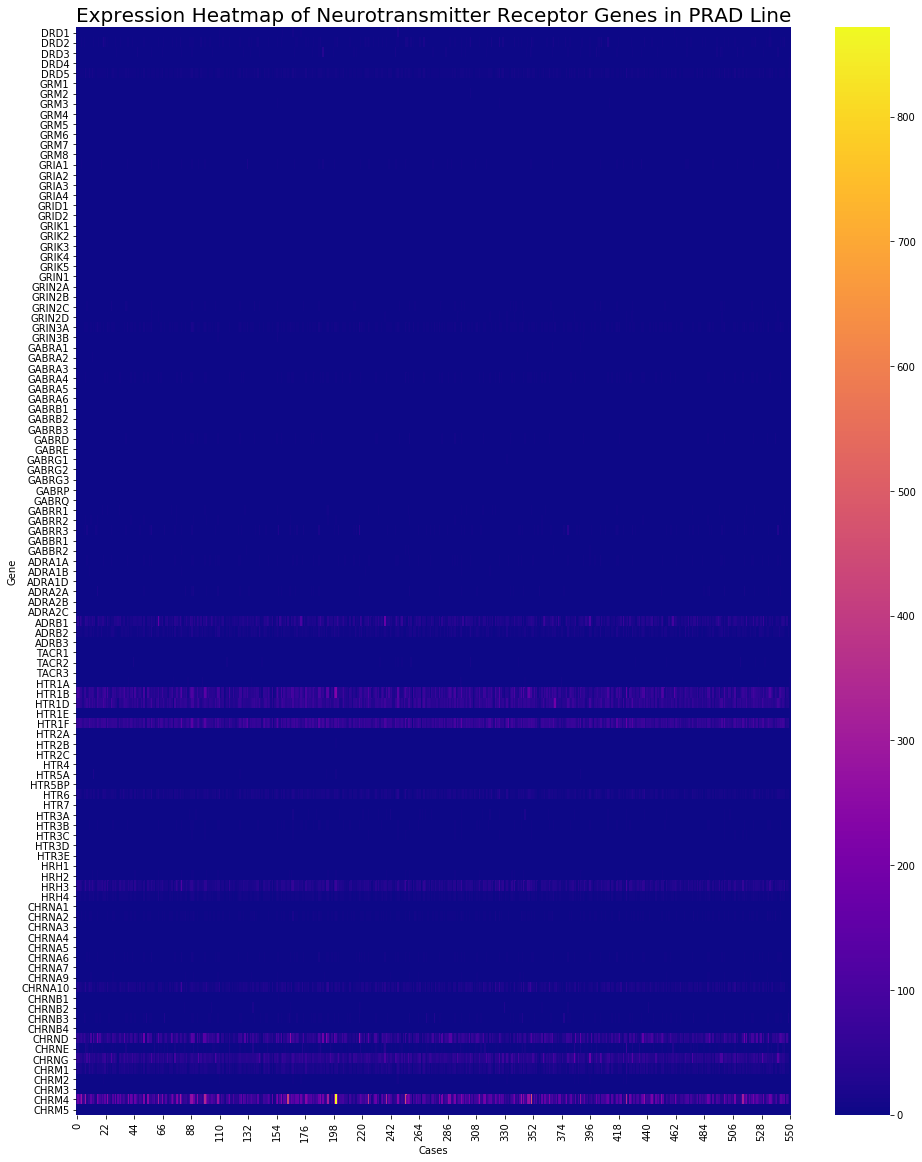

In [22]:
draw_expression_heatmap(prad_tpm, prad_tpm['hgnc_symbol'].tolist(), 'plasma', 'Expression Heatmap of Neurotransmitter Receptor Genes in PRAD Line', 16, 20, False)

Z-Score TPM Heatmap:

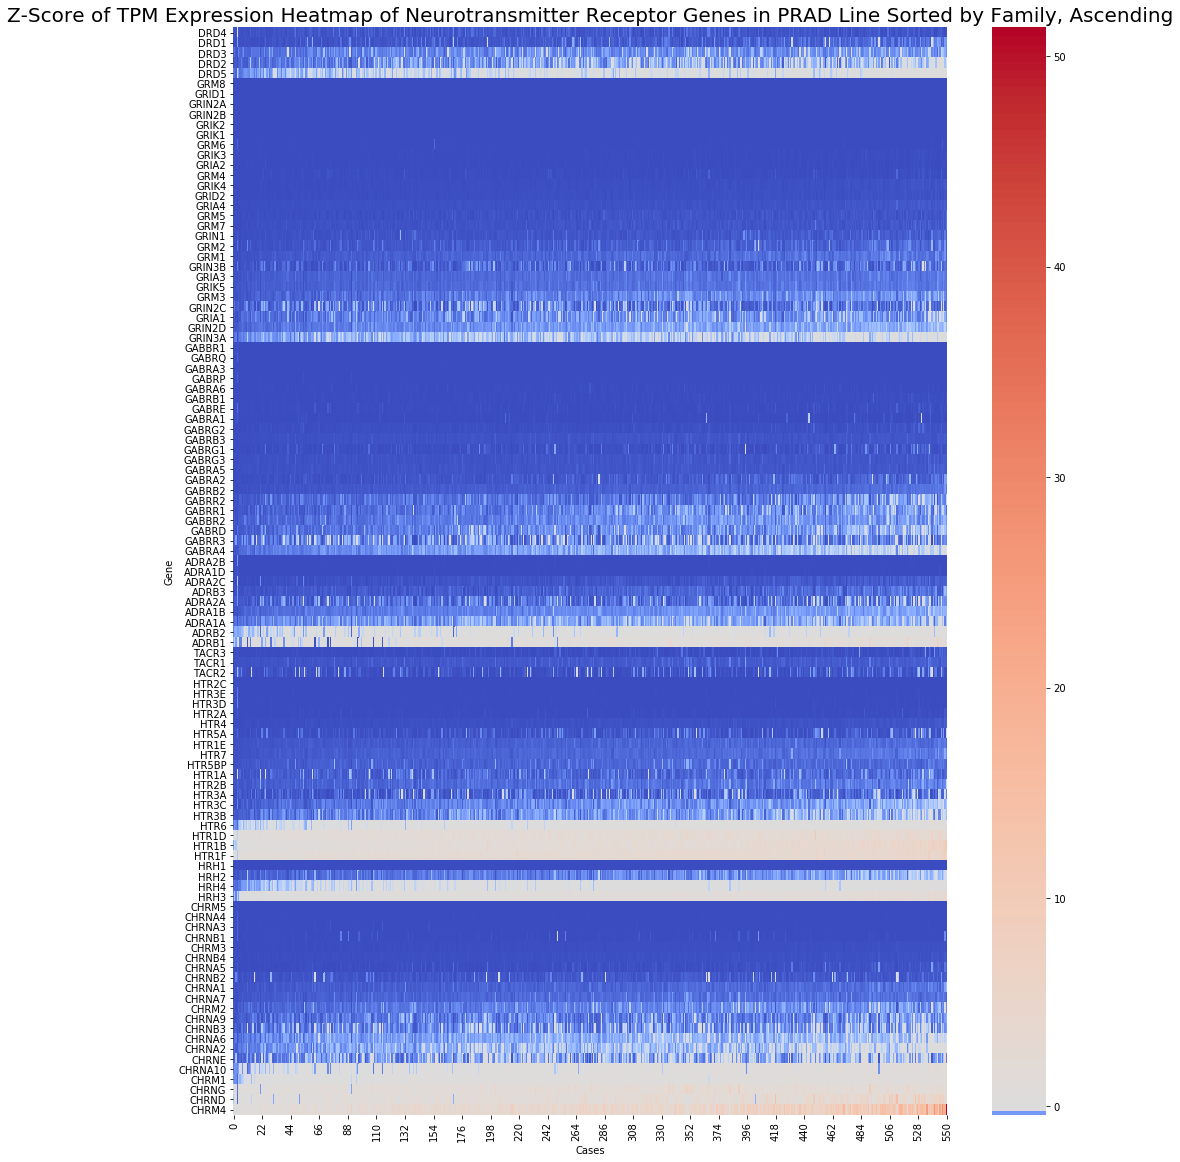

In [23]:
draw_expression_log_heatmap(prad_tpm, prad_tpm['hgnc_symbol'].tolist(), '', 'Z-Score of TPM Expression Heatmap of Neurotransmitter Receptor Genes in PRAD Line Sorted by Family, Ascending', True, True, 'coolwarm', 16, 20, False)

Z-Score of Ln (TPM + 1) Heatmap:

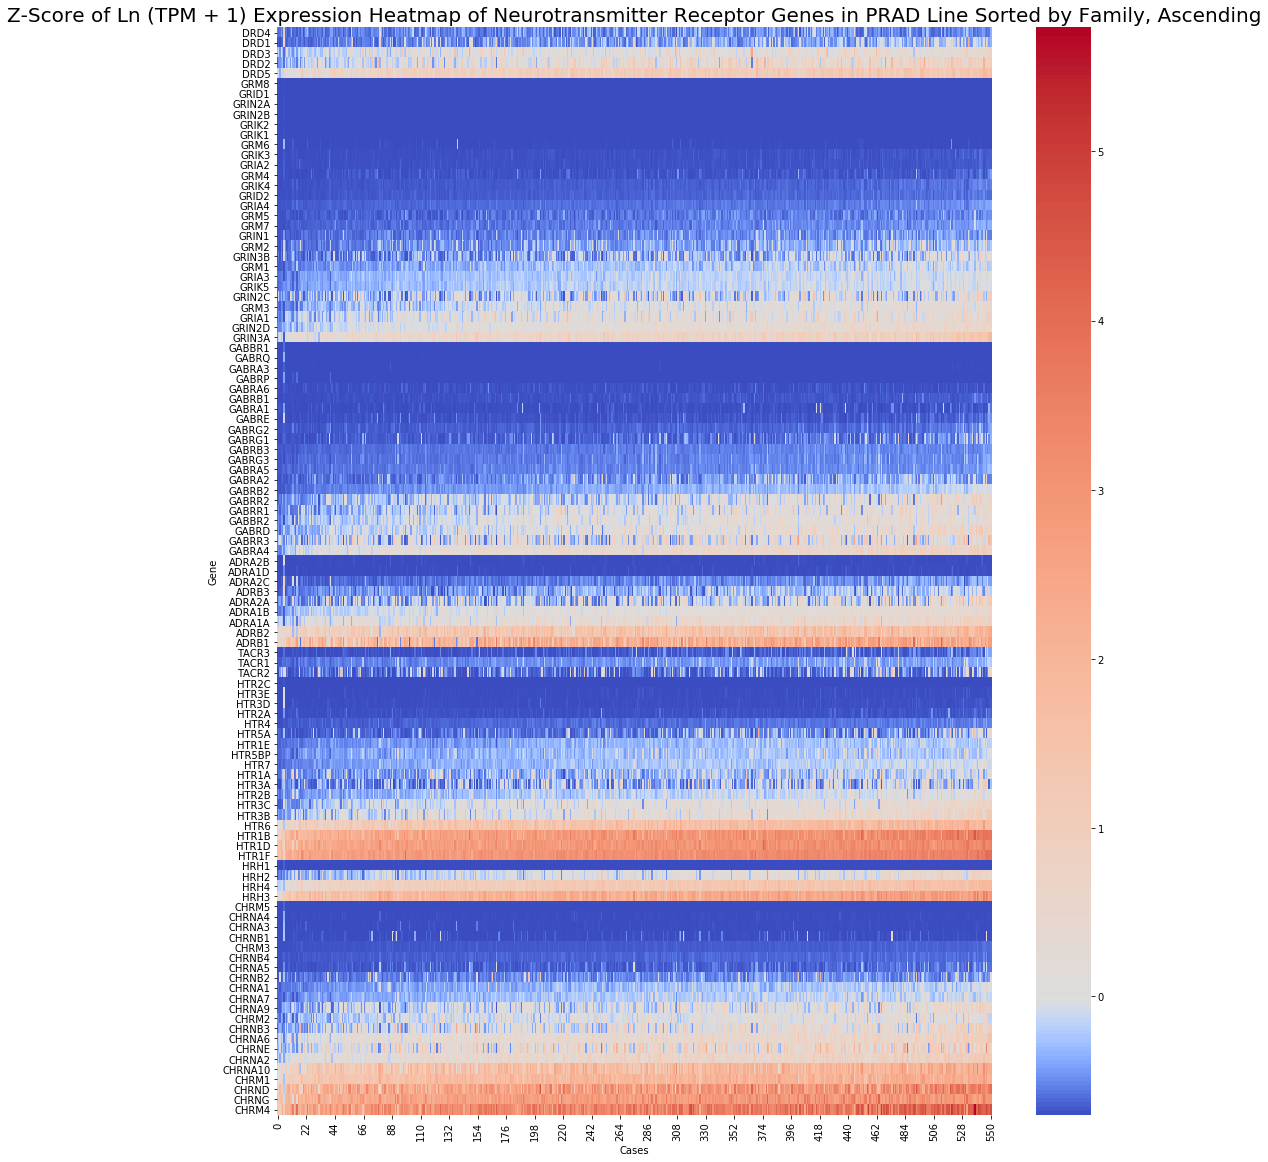

In [24]:
draw_expression_log_heatmap(prad_tpm, prad_tpm['hgnc_symbol'].tolist(), 'natural', 'Z-Score of Ln (TPM + 1) Expression Heatmap of Neurotransmitter Receptor Genes in PRAD Line Sorted by Family, Ascending', True, True, 'coolwarm', 16, 20, False)

# Part 3: Additional Cell Lines

Given additional pancreatic cell lines, we can calculate the TPMs and create heatmaps for them.

In [25]:
panc_all = pd.read_csv('datasets/pancreas_cell_line.csv')

In [26]:
panc_tpm = make_tpm(panc_all)

In [27]:
panc_tpm

,hgnc_symbol,PANC1,MIAPACA2,HPAC,CAPAN2,BXPC3,CAPAN1
17385,DRD1,13.1869,0.0255165,0,1.31461,0.0486834,8.23429
32688,DRD2,0.487819,0.00320162,0.00275831,0.0445969,0.00229067,0.0034166
10805,DRD3,0,0,0.000507568,0,0,0
30109,DRD4,0.496655,3.35503,0.403075,0.857502,0.616623,1.15621
12526,DRD5,0,0.0222718,0,0.0169992,0.382436,0
...,...,...,...,...,...,...,...
31564,CHRM1,0.0334357,0.0241753,0.0249934,0.0307534,0.026906,0.0722361
22736,CHRM2,0.000965225,0,0.00192403,0.000266338,0,0
4997,CHRM3,0.000461077,0.000200026,0.0159232,0.00244275,0.0259511,0.00264687
31030,CHRM4,10.8202,2.03175,0.217294,0.962536,1.67087,3.17002


In [28]:
# here we are importing the tpm file from cancer_expression_heatmap.ipynb so we have the tpm of the paad cohort
# we're averaging across rows and then creating a new table with just the average
def average_tpm(file):
    table = pd.read_csv(file)
    table.drop('Unnamed: 0', axis=1, inplace=True)
    hgnc = table['hgnc_symbol']
    table.drop('hgnc_symbol', axis=1, inplace=True)
    table['Tumor'] = table.mean(axis=1)
    table.insert(0, 'hgnc_symbol', hgnc)
    averaged = table[['Tumor']].copy()
    averaged.insert(0, 'hgnc_symbol', hgnc)
    averaged_filtered = filter_genes_of_interest(averaged)
    averaged_sorted = sort_genes_of_interest(averaged_filtered)
    return averaged_sorted
    

In [29]:
tumor_tpm = average_tpm('datasets/tpm_rnaseq_values.csv')

In [30]:
tumor_tpm.loc[tumor_tpm['hgnc_symbol'] == 'ADRB2']

,hgnc_symbol,Tumor
524,ADRB2,13.702373


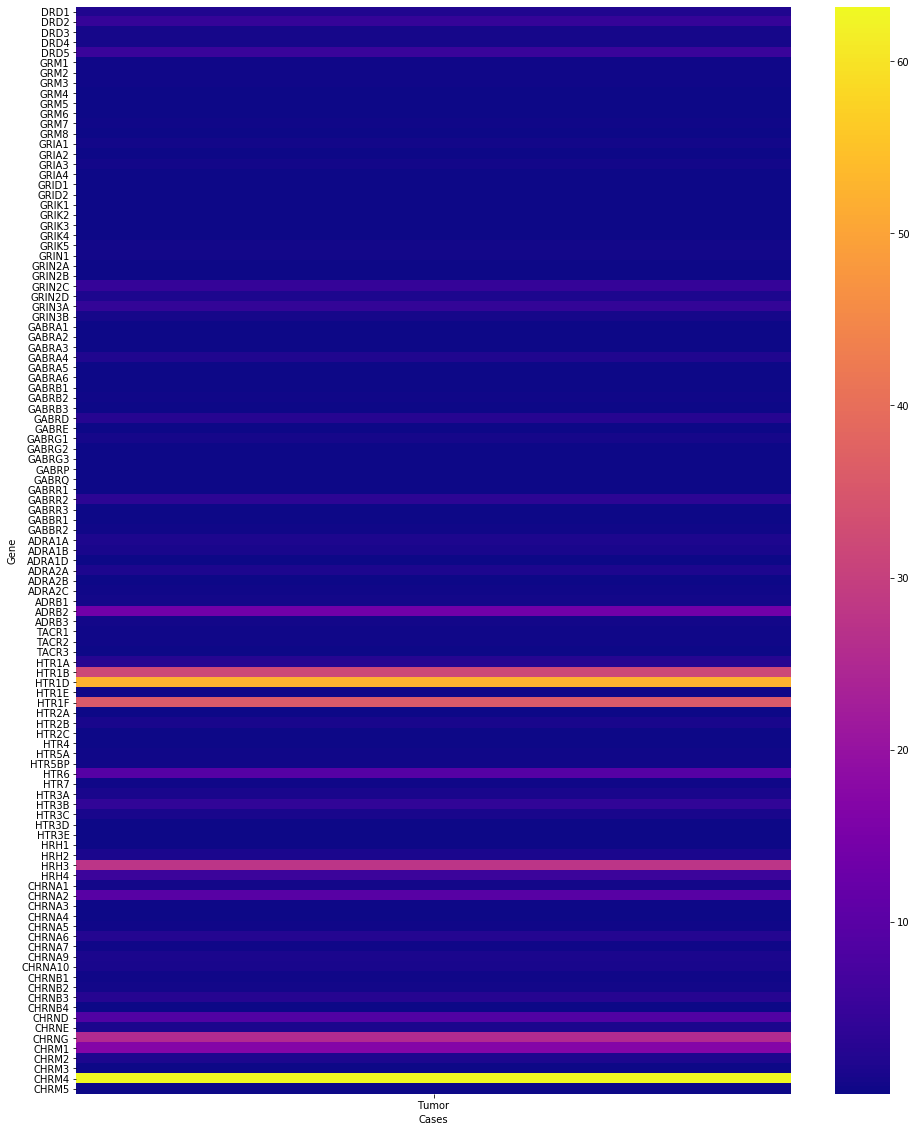

In [31]:
draw_expression_heatmap(tumor_tpm, tumor_tpm['hgnc_symbol'].tolist(), 'plasma', '', 16, 20, False)

In [32]:
tumor_panc_tpm = pd.merge(tumor_tpm, panc_tpm, on='hgnc_symbol')

In [33]:
tumor_panc_tpm

,hgnc_symbol,Tumor,PANC1,MIAPACA2,HPAC,CAPAN2,BXPC3,CAPAN1
0,DRD1,1.825896,13.1869,0.0255165,0,1.31461,0.0486834,8.23429
1,DRD2,4.617089,0.487819,0.00320162,0.00275831,0.0445969,0.00229067,0.0034166
2,DRD3,0.803724,0,0,0.000507568,0,0,0
3,DRD4,0.854273,0.496655,3.35503,0.403075,0.857502,0.616623,1.15621
4,DRD5,5.415738,0,0.0222718,0,0.0169992,0.382436,0
...,...,...,...,...,...,...,...,...
102,CHRM1,16.931017,0.0334357,0.0241753,0.0249934,0.0307534,0.026906,0.0722361
103,CHRM2,1.677587,0.000965225,0,0.00192403,0.000266338,0,0
104,CHRM3,0.059905,0.000461077,0.000200026,0.0159232,0.00244275,0.0259511,0.00264687
105,CHRM4,63.173471,10.8202,2.03175,0.217294,0.962536,1.67087,3.17002


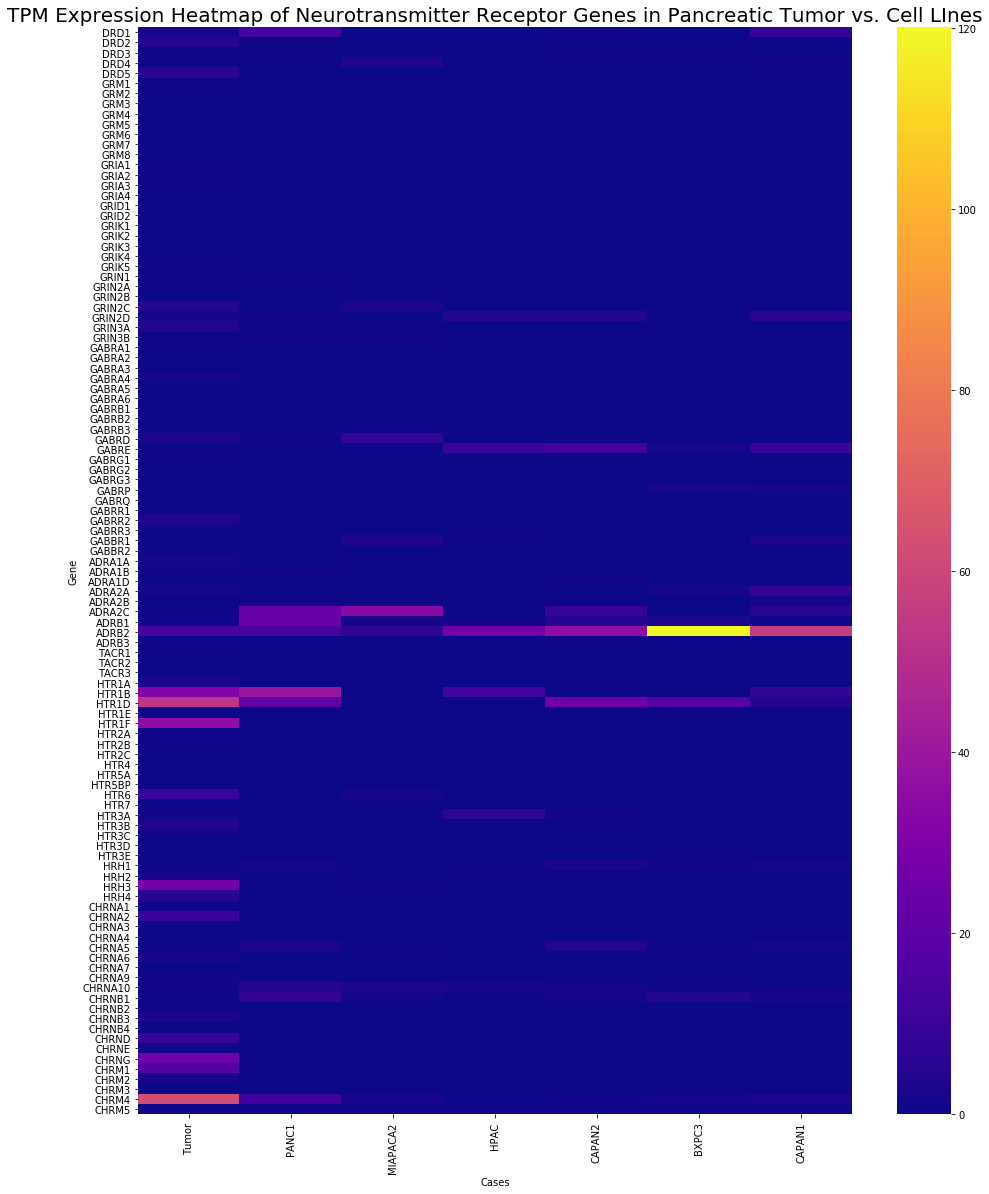

In [34]:
draw_expression_heatmap(tumor_panc_tpm, tumor_panc_tpm['hgnc_symbol'].tolist(), 'plasma', 'TPM Expression Heatmap of Neurotransmitter Receptor Genes in Pancreatic Tumor vs. Cell LInes', 16, 20, True)

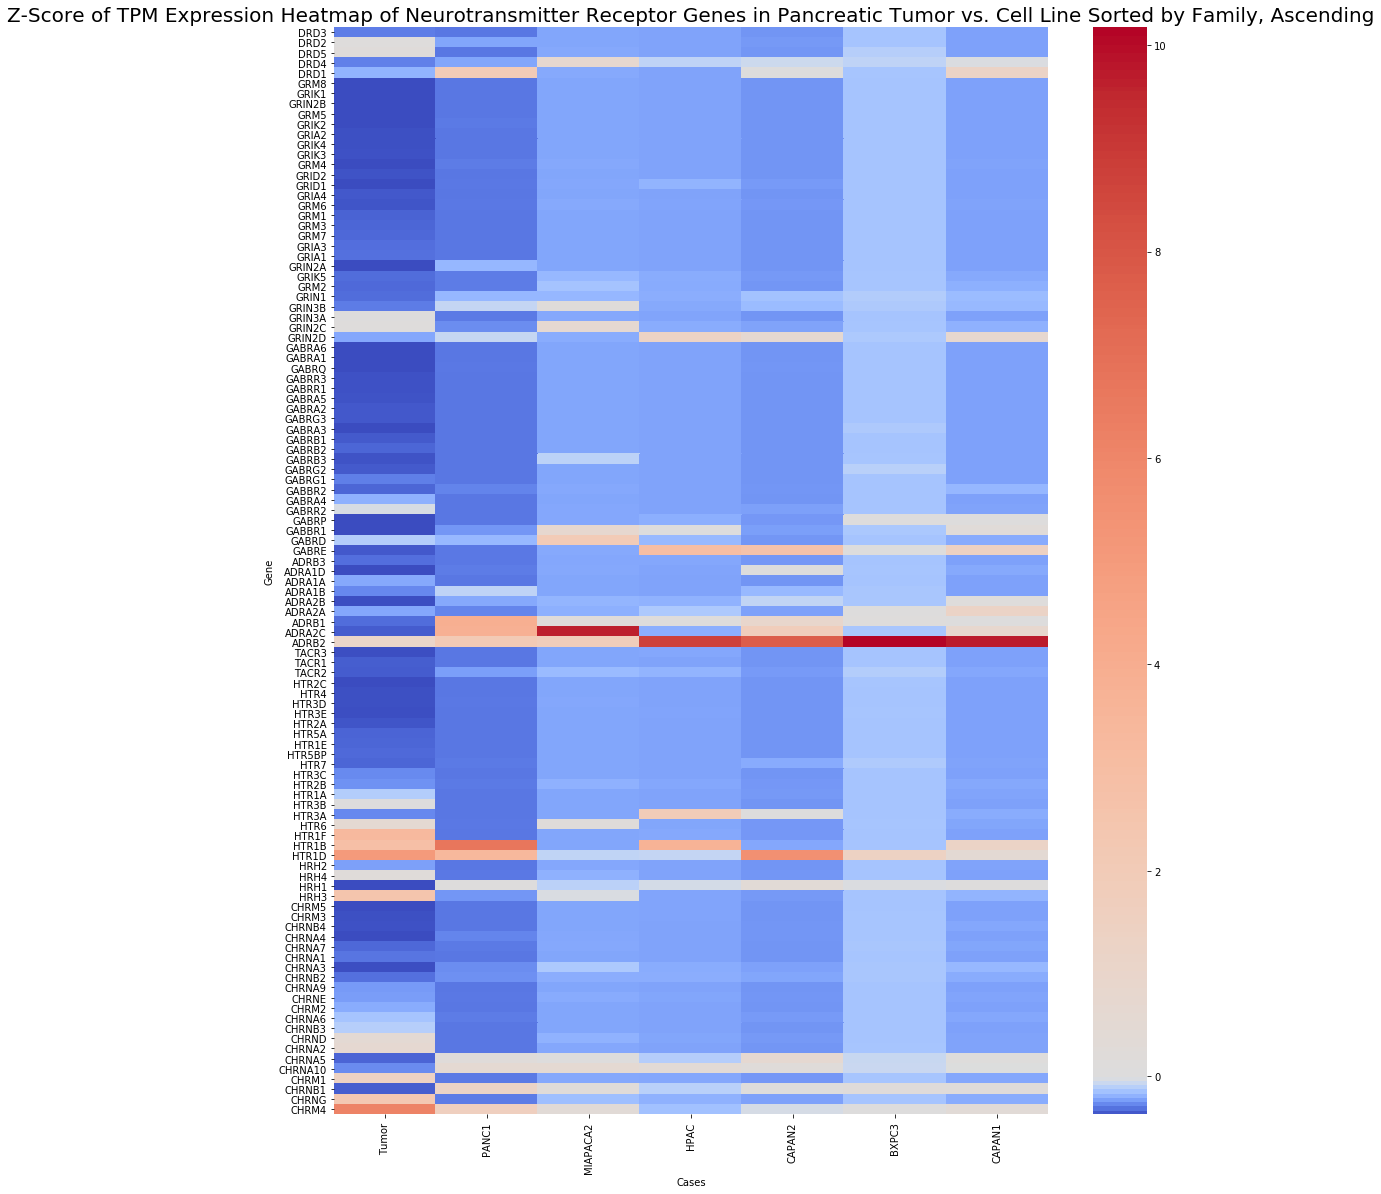

In [35]:
draw_expression_log_heatmap(tumor_panc_tpm, tumor_panc_tpm['hgnc_symbol'].tolist(), '', 'Z-Score of TPM Expression Heatmap of Neurotransmitter Receptor Genes in Pancreatic Tumor vs. Cell Line Sorted by Family, Ascending', True, True, 'coolwarm', 16, 20, True)

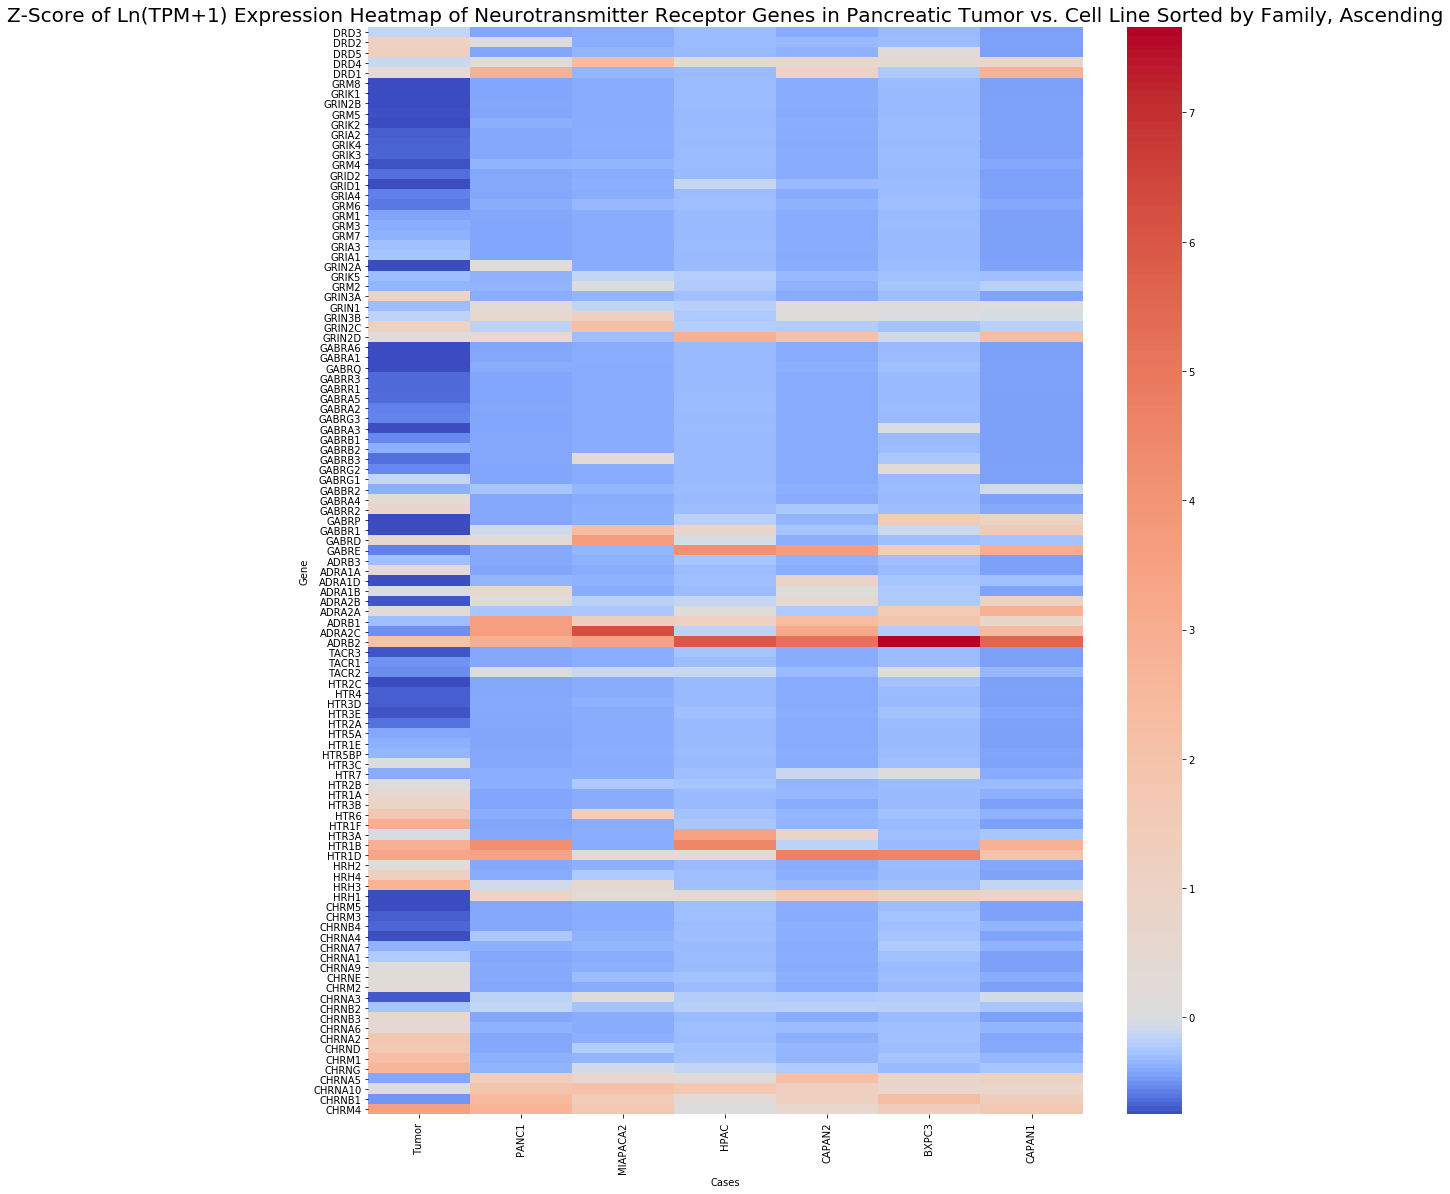

In [44]:
draw_expression_log_heatmap(tumor_panc_tpm, tumor_panc_tpm['hgnc_symbol'].tolist(), 'natural', 'Z-Score of Ln(TPM+1) Expression Heatmap of Neurotransmitter Receptor Genes in Pancreatic Tumor vs. Cell Line Sorted by Family, Ascending', True, True, 'coolwarm', 16, 20, True)